# Preprocessing

Note that this step is optional. If the data do not yet have one of `X_pca`, `X_emb`, or `state_info`, you will need to run the preprocessing and dimension reduction. 

In [2]:
import os
os.chdir(r'/Users/mac/Desktop/YSLabStorage_Synosnc/study/phd_new/CoSpar/cospar-master')

In [3]:
import cospar as cs

In [9]:
cs.logging.print_version()
cs.settings.verbosity = 2  # range: 0 (error),1 (warning),2 (info),3 (hint).
cs.settings.set_figure_params(
    format="png", figsize=[4, 3.5], dpi=75, fontsize=14, pointsize=3
)

Running cospar 0.3.0 (python 3.9.16) on 2023-07-13 16:33.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [10]:
# Each dataset should have its folder to avoid conflicts.
cs.settings.data_path = "data_cospar"
cs.settings.figure_path = "fig_cospar"
cs.hf.set_up_folders()

Load an existing dataset. (If you have pre-processed data, you can load it with `cs.hf.read(file_name)`.)

In [11]:
adata_orig = cs.datasets.hematopoiesis_subsampled()

## Dimension reduction

Select highly variable genes. Before this, there is count normalization. It requires that the count matrix is **NOT** log-normalized.

Finding highly variable genes...


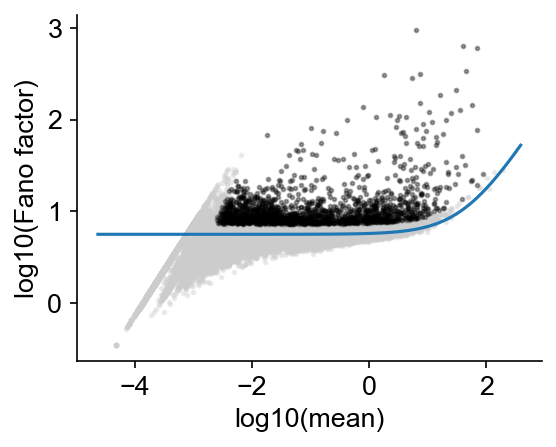

Keeping 1615 genes


In [12]:
cs.pp.get_highly_variable_genes(
    adata_orig,
    normalized_counts_per_cell=10000,
    min_counts=3,
    min_cells=3,
    min_gene_vscore_pctl=90,
)

Compute for each gene its correlation with a set of cell cycle genes. The default cell cycle genes are for mouse.
You need to use your own genes for a different species. This step is optional, but recommended. 

adata.var['highly_variable'] not updated.
Please choose corr_threshold properly, and set confirm_change=True


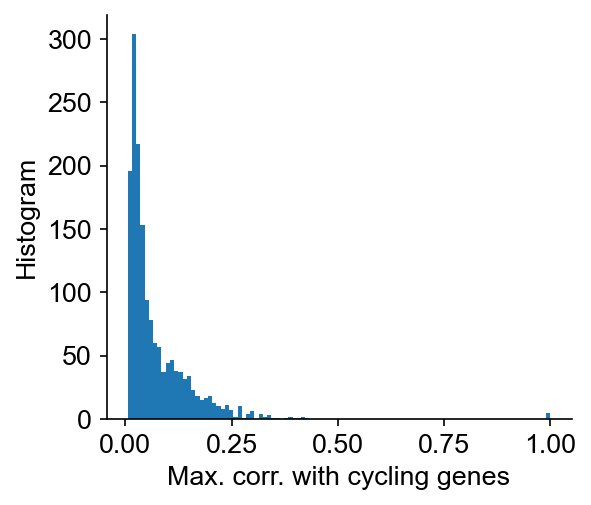

In [13]:
cs.pp.remove_cell_cycle_correlated_genes(
    adata_orig,
    cycling_gene_list=[
        "Ube2c",
        "Hmgb2",
        "Hmgn2",
        "Tuba1b",
        "Ccnb1",
        "Tubb5",
        "Top2a",
        "Tubb4b",
    ],
)

Now, confirm the change at a specific cutoff threshold. 

In [14]:
cs.pp.remove_cell_cycle_correlated_genes(
    adata_orig, corr_threshold=0.2, confirm_change=True
)

Number of selected non-cycling highly variable genes: 1508
Remove 107 cell cycle correlated genes.
adata.var['highly_variable'] updated


Compute the `X_pca`, `X_emb`. `X_pca` will be used to build the similarity matrix later. `X_emb` is only used for visualization. You can also pass your favorite embedding directly to 
`adata.obsm['X_emb']`.

In [15]:
cs.pp.get_X_pca(adata_orig, n_pca_comp=40)
cs.pp.get_X_emb(adata_orig, n_neighbors=20, umap_min_dist=0.3)

/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator

Note that previous `X_pca` and `X_emb` (if exists) will be kept and renamed as `X_pca_old` and `X_emb_old`

In [16]:
adata_orig

AnnData object with n_obs × n_vars = 7438 × 25289
    obs: 'time_info', 'state_info', 'NeuMon_fate_bias', 'NeuMon_mask', 'progenitor_Ccr7_DC', 'progenitor_Mast', 'progenitor_Meg', 'progenitor_pDC', 'progenitor_Eos', 'progenitor_Lymphoid', 'progenitor_Erythroid', 'progenitor_Baso', 'progenitor_Neutrophil', 'progenitor_Monocyte', 'sp_500_idx', 'MLPClassifier_predicted_bias', 'n_counts'
    var: 'highly_variable'
    uns: 'available_map', 'clonal_time_points', 'data_des', 'progenitor_Monocyte_colors', 'state_info_colors', 'time_ordering', 'neighbors', 'umap'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_pca_old', 'X_umap', 'X_emb_old'
    obsp: 'distances', 'connectivities'

/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


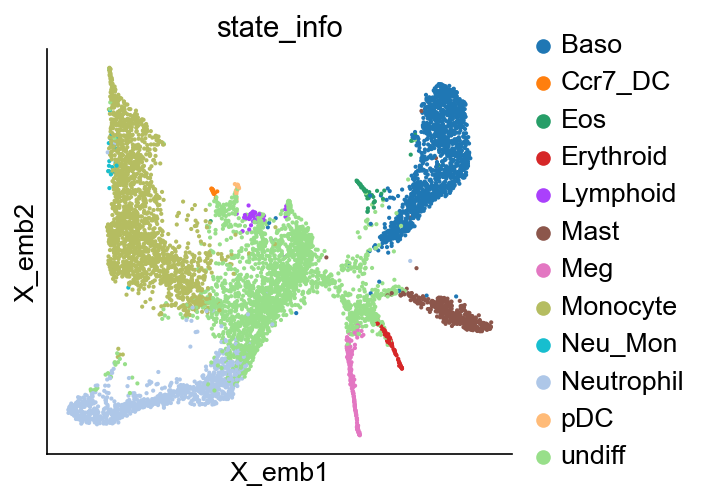

In [17]:
cs.pl.embedding(adata_orig, color="state_info")

## State annotation

This generates `adata_orig.obs['state_info']`. 

In [18]:
cs.pp.get_state_info(adata_orig, n_neighbors=20, resolution=0.5)

/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


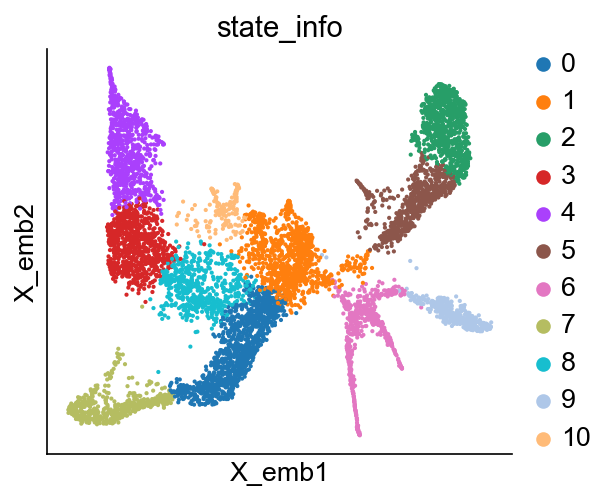

In [19]:
cs.pl.embedding(adata_orig, color="state_info")

Similarly, the pre-existing `state_info` will be renamed

In [20]:
adata_orig

AnnData object with n_obs × n_vars = 7438 × 25289
    obs: 'time_info', 'state_info', 'NeuMon_fate_bias', 'NeuMon_mask', 'progenitor_Ccr7_DC', 'progenitor_Mast', 'progenitor_Meg', 'progenitor_pDC', 'progenitor_Eos', 'progenitor_Lymphoid', 'progenitor_Erythroid', 'progenitor_Baso', 'progenitor_Neutrophil', 'progenitor_Monocyte', 'sp_500_idx', 'MLPClassifier_predicted_bias', 'n_counts', 'leiden', 'state_info_old'
    var: 'highly_variable'
    uns: 'available_map', 'clonal_time_points', 'data_des', 'progenitor_Monocyte_colors', 'state_info_colors', 'time_ordering', 'neighbors', 'umap', 'leiden'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_pca_old', 'X_umap', 'X_emb_old'
    obsp: 'distances', 'connectivities'

### Refine state annotation by marker genes

The goal here is to refine `adata_orig.obs['state_info']`. In this method, a state is selected if it expresses all genes in the list of 
`marker_genes`, and the expression is above the relative threshold `express_threshold`. 
You can also specify which time point you want to focus on. In addition, we also 
include cell states neighboring to these valid states to smooth 
the selection (controlled by `add_neighbor_N`). First, explore parameters to find satisfactory annotation.

/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


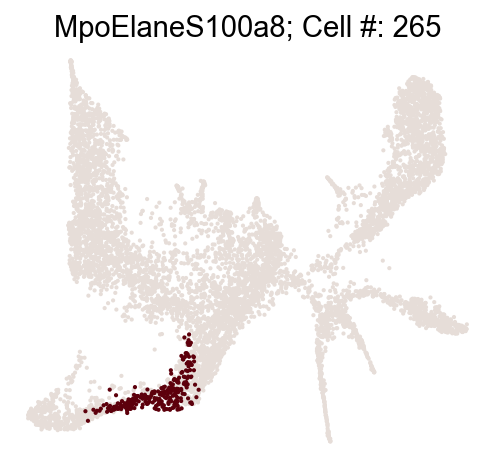

In [24]:
confirm_change = False
marker_genes = ["Mpo", "Elane", "S100a8"]
cs.pp.refine_state_info_by_marker_genes(
    adata_orig,
    marker_genes,
    express_threshold=0.1,
    selected_key="time_info",
    selected_values=["4"],
    new_cluster_name="new",
    add_neighbor_N=10,
    confirm_change=confirm_change,
)

Once you are happy with the result, set `confirm_change=True` to confirm changes to `adata.obs['state_info']`.

/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Change state annotation at adata.obs['state_info']


/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


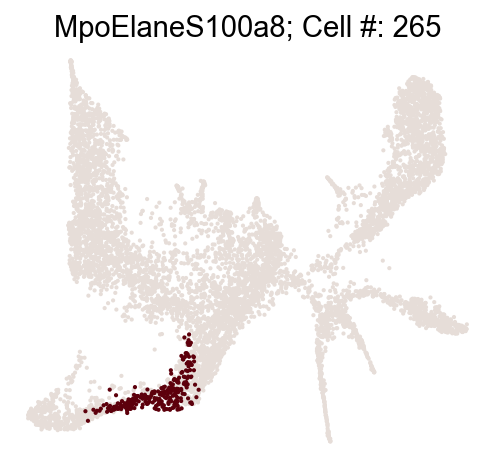

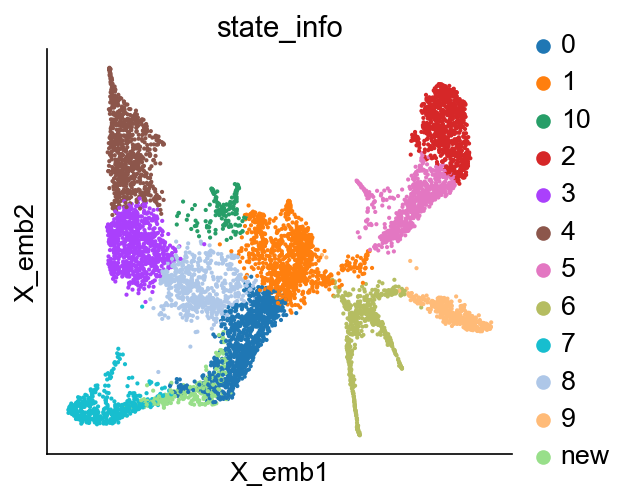

In [26]:
confirm_change = True
marker_genes = ["Mpo", "Elane", "S100a8"]
cs.pp.refine_state_info_by_marker_genes(
    adata_orig,
    marker_genes,
    express_threshold=0.1,
    selected_key = "time_info",
    selected_values=["4"],
    new_cluster_name="new",
    add_neighbor_N=10,
    confirm_change=True,
)

### Refine state annotation by clustering states at given time points

First, explore the parameters.

/opt/anaconda3/envs/cospar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


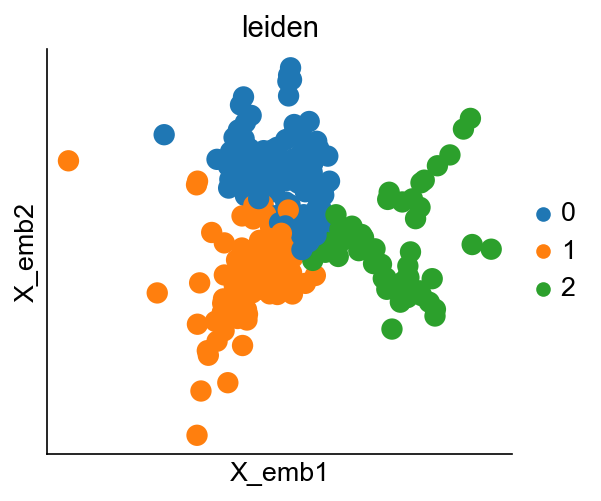

In [30]:
confirm_change = False
cs.pp.refine_state_info_by_leiden_clustering(
    adata_orig,
    selected_key="time_info",
    selected_values=["2"],
    n_neighbors=20,
    resolution=0.5,
    confirm_change=confirm_change,
)

Once you are happy with the result, set `confirm_change=True` to confirm changes to `adata.obs['state_info']`.

## Miscellaneous

In [31]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['6', '0', '4', '1', '8', '5', 'new', '10', '7', '3', '9', '2']
Available time points: ['2' '4' '6']
Clonal time points: ['2' '4' '6']


You can choose to save preprocessed data. It can be loaded using `cs.hf.read(file_name)`. 

In [18]:
# cs.hf.save_preprocessed_adata(adata_orig)